# importiranje programskih biblioteka

In [1]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, Descriptors

# importiranje i pregled sirovih podataka

In [2]:
sirovi_podaci=pd.read_csv('data/solubility.txt',\
delim_whitespace=True,names=['cas','smiles','logs'])

In [3]:
sirovi_podaci.head()

,cas,smiles,logs
0,60-35-5,CC(N)=O,1.58
1,60-34-4,CNN,1.34
2,64-19-7,CC(O)=O,1.22
3,123-75-1,C1CCCN1,1.15
4,127-07-1,NC([NH]O)=O,1.12


# pretvaranje SMILES u mol zapis strukture

In [4]:
mol_column=sirovi_podaci.smiles.apply(Chem.MolFromSmiles).rename('mol', inplace=True)

# računanje deskriptora

In [5]:
logp=mol_column.apply(Descriptors.MolLogP).rename('logp', inplace=True)
molwt=mol_column.apply(Descriptors.MolWt).rename('molwt', inplace=True)
balabanj=mol_column.apply(Descriptors.BalabanJ).rename('balabanj', inplace=True)
tpsa=mol_column.apply(Descriptors.TPSA).rename('tpsa', inplace=True)

# fuzija sirovih podataka i deskriptora

In [6]:
final_data=pd.concat([sirovi_podaci, mol_column, logp, molwt, balabanj, tpsa], axis=1)
final_data.head(4)

,cas,smiles,logs,mol,logp,molwt,balabanj,tpsa
0,60-35-5,CC(N)=O,1.58,<rdkit.Chem.rdchem.Mol object at 0x000001A92A4...,-0.5084,59.068,2.803039,43.09
1,60-34-4,CNN,1.34,<rdkit.Chem.rdchem.Mol object at 0x000001A92A4...,-0.9205,46.073,1.632993,38.05
2,64-19-7,CC(O)=O,1.22,<rdkit.Chem.rdchem.Mol object at 0x000001A92A4...,0.0909,60.052,2.803039,37.30
3,123-75-1,C1CCCN1,1.15,<rdkit.Chem.rdchem.Mol object at 0x000001A92A4...,0.3698,71.123,2.083333,12.03


#final_data.to_csv('data/solubility_all_data.csv')

# razdvajanje podataka na trening i test set

In [7]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(final_data, test_size=.2, random_state=42)
train_set.shape, test_set.shape

((1048, 8), (263, 8))

# vizualizacija odnosa varijabli

In [8]:
train_set[['logp','molwt','tpsa','balabanj','logs']].corr()

,logp,molwt,tpsa,balabanj,logs
logp,1.000000,0.451401,-0.513134,-0.162983,-0.840738
molwt,0.451401,1.000000,0.412144,-0.359005,-0.639202
tpsa,-0.513134,0.412144,1.000000,-0.069396,0.185571
balabanj,-0.162983,-0.359005,-0.069396,1.000000,0.232376
logs,-0.840738,-0.639202,0.185571,0.232376,1.000000


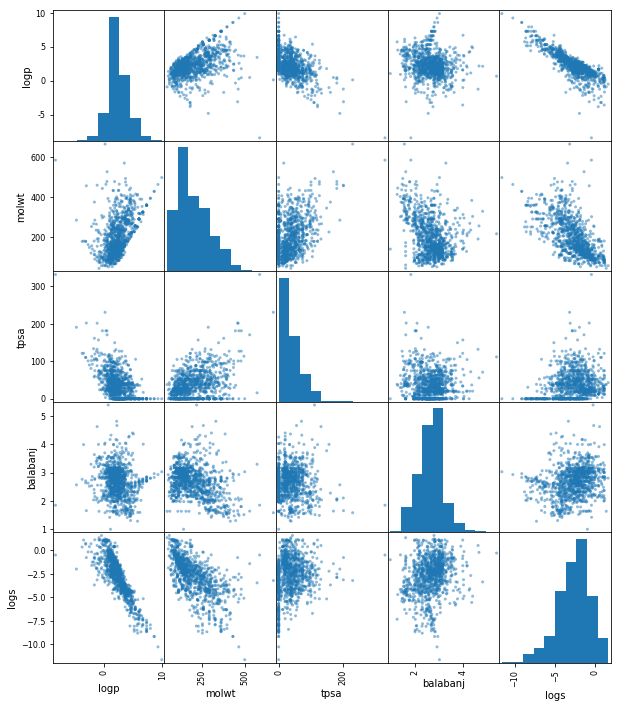

In [9]:
from pandas.plotting import scatter_matrix
%matplotlib inline
scatter_matrix(train_set[['logp','molwt','tpsa','balabanj','logs']], figsize=(10,12));

# izbor najbolje varijable

In [10]:
from sklearn.feature_selection import f_regression

In [11]:
help(f_regression)

Help on function f_regression in module sklearn.feature_selection.univariate_selection:

f_regression(X, y, center=True)
    Univariate linear regression tests.
    
    Linear model for testing the individual effect of each of many regressors.
    This is a scoring function to be used in a feature seletion procedure, not
    a free standing feature selection procedure.
    
    This is done in 2 steps:
    
    1. The correlation between each regressor and the target is computed,
       that is, ((X[:, i] - mean(X[:, i])) * (y - mean_y)) / (std(X[:, i]) *
       std(y)).
    2. It is converted to an F score then to a p-value.
    
    For more on usage see the :ref:`User Guide <univariate_feature_selection>`.
    
    Parameters
    ----------
    X : {array-like, sparse matrix}  shape = (n_samples, n_features)
        The set of regressors that will be tested sequentially.
    
    y : array of shape(n_samples).
        The data matrix
    
    center : True, bool,
        If true, X

In [12]:
featsel=f_regression(X=train_set[['logp','molwt','tpsa','balabanj']], y=train_set['logs'])
F_values=featsel[0]
P_values=featsel[1]
P_values

array([  5.79397574e-281,   1.94076230e-121,   1.42230093e-009,
         2.57225427e-014])

# treniranje modela

In [13]:
from sklearn.linear_model import LinearRegression as linreg

In [14]:
xtrain=np.array(train_set.logp)[:, np.newaxis]
ytrain=np.array(train_set.logs)
xtest=np.array(test_set.logp)[:, np.newaxis]
y_true=np.array(test_set.logs)

In [15]:
fitter=linreg().fit(X=xtrain, y=ytrain)
a=fitter.coef_
b=fitter.intercept_
a, b

(array([-0.95544944]), -0.55785964516979414)

# fitanje modela i predikcija

In [16]:
y_pred=fitter.predict(X=xtest)

# vizualizacija predikcije

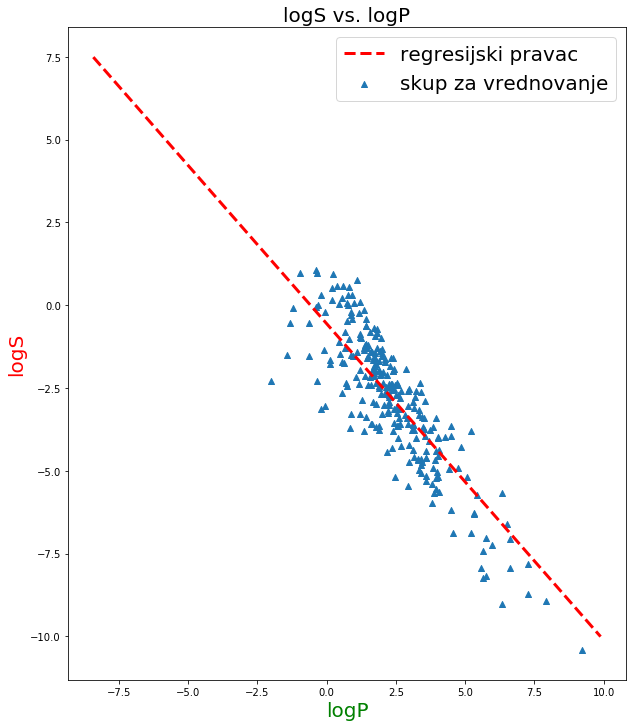

In [17]:
import matplotlib.pyplot as plt
fig, ax =plt.subplots(figsize=(10,12))
#scatter plot
plt.scatter(x=test_set.logp, y=test_set.logs, marker='^', label='skup za vrednovanje')
#regresijska linija
x_space=np.array([min(train_set.logp),max(train_set.logp)])
y_fit=x_space*a + b
plt.plot(x_space,y_fit, linestyle='--', c='r', lw=3, label="regresijski pravac")
#
plt.ylabel('logS', fontsize=20, color='red')
plt.xlabel('logP', fontsize=20, color='green')
plt.title('logS vs. logP', fontsize=20)
plt.legend(fontsize=20)

# kvaliteta predikcije

In [ ]:
import seaborn as sns
sns.residplot(y_true,y_pred)
from sklearn.metrics import mean_squared_error as MSE
'MSE:',MSE(y_true, y_pred)

In [ ]:
pd.DataFrame((y_pred-y_true)).hist()

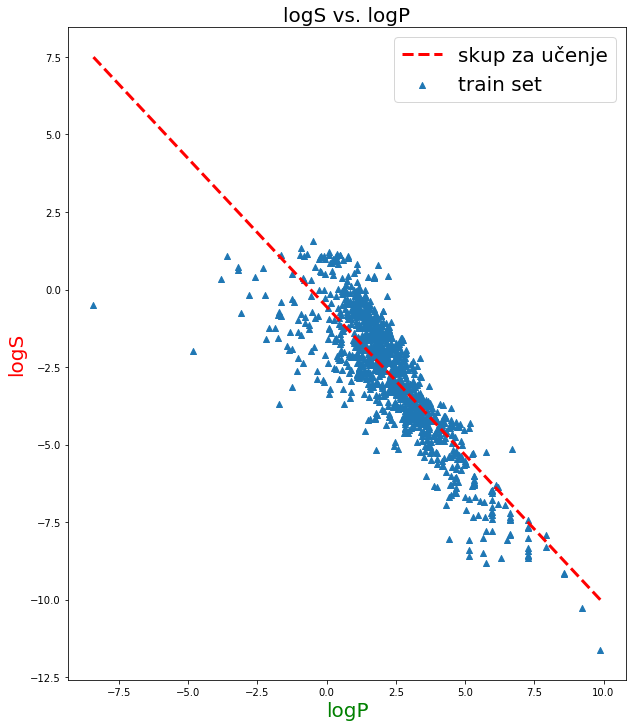

In [18]:
fig, ax =plt.subplots(figsize=(10,12))
#scatter plot
plt.scatter(x=train_set.logp, y=train_set.logs, marker='^', label='train set')
#regresijska linija
x_space=np.array([min(train_set.logp),max(train_set.logp)])
y_fit=x_space*fitter.coef_ + fitter.intercept_
ax.plot(x_space,y_fit, linestyle='--', c='r', lw=3, label='skup za učenje')
#
ax.set_ylabel('logS', fontsize=20, color='red')
ax.set_xlabel('logP', fontsize=20, color='green')
ax.set_title('logS vs. logP', fontsize=20)
plt.legend(fontsize=20)

In [ ]:
train_set[['logs','logp']].describe()

In [ ]:
train_set[['logs','logp']].plot.box(figsize=(5,10), grid=True)

In [ ]:
import statsmodels.api as sm
x_sm=sm.add_constant(xtrain)
model = sm.OLS(ytrain, x_sm)
fitted_model = model.fit()

fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.influence_plot(fitted_model , alpha  = 0.05, ax=ax, criterion="cooks")

In [ ]:
xtrain[941]

In [ ]:
xtrain[692]

In [ ]:
train_set[train_set.logp<-4.8][['smiles','logp']]

In [ ]:
outlier1=train_set.smiles.loc[1056]
outlier2=train_set.smiles.loc[105]

In [ ]:
o1_mol=Chem.MolFromSmiles(outlier1)
AllChem.Compute2DCoords(o1_mol)
print(Chem.MolToMolBlock(o1_mol))  

In [ ]:
Draw.MolToImage(o1_mol)

In [ ]:
o2_mol=Chem.MolFromSmiles(outlier2)
AllChem.Compute2DCoords(o2_mol)
Draw.MolToImage(o2_mol)